In [1]:
from anndata import AnnData
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq

import os, warnings 
warnings.filterwarnings('ignore') 
import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

## Comparison by mean

In [2]:
sample_list = [
    "V1_Human_Lymph_Node",
    "Parent_Visium_Human_Glioblastoma",
    "Breast_Wu_1142243F", "Breast_Wu_1160920F", "Breast_Wu_CID4465", 
    "Breast_Wu_CID44971", "Breast_Wu_CID4290", "Breast_Wu_CID4535"]
method_list = ['TransPath', 'UNI', 'Pixel', 'BiGAN']
rows = ['Coord only'] + [f'$\omega$={w}' for w in ['0.025', '0.05', '0.075', '0.1', '0.125', '0.15',
       '0.175', '0.2', '0.225', '0.25', '0.275', '0.3', '0.325', '0.35',
       '0.375', '0.4', '0.425', '0.45', '0.475', '0.5', '0.525', '0.55',
       '0.575', '0.6', '0.625', '0.65', '0.675', '0.7', '0.725', '0.75',
       '0.775', '0.8', '0.825', '0.85', '0.875', '0.9', '0.925', '0.95',
       '0.975', '1']] + ['Image only']

dfs_mean = dict()
dfs_std = dict()
for sample in sample_list:
    dfs_std[sample] = pd.read_csv(f'outputs_image_weight/std/{sample}.csv', index_col=0)
    dfs_std[sample].index = rows
    dfs_std[sample].columns = method_list
    dfs_mean[sample] = dfs_std[sample] * 0


In [3]:
rows_temp = ['Coord only'] + [f'$\omega$={w}' for w in ['0.0', '0.025', '0.05', '0.075', '0.1', '0.125', '0.15',
       '0.175', '0.2', '0.225', '0.25', '0.275', '0.3', '0.325', '0.35',
       '0.375', '0.4', '0.425', '0.45', '0.475', '0.5', '0.525', '0.55',
       '0.575', '0.6', '0.625', '0.65', '0.675', '0.7', '0.725', '0.75',
       '0.775', '0.8', '0.825', '0.85', '0.875', '0.9', '0.925', '0.95',
       '0.975', '1']] + ['Image only']

for method in method_list:
    df_mean_temp = pd.read_csv(f'outputs_image_weight/mean_new/df_cor_{method}.csv', index_col=0)
    df_mean_temp.index = rows_temp
    for sample in sample_list:
        dfs_mean[sample][method] = df_mean_temp[sample]

In [4]:
dfs_merged = dict()
for sample in sample_list:
    df1 = dfs_mean[sample]
    df2 = dfs_std[sample]
    df1 = df1.stack().reset_index().rename(columns={'level_0':'Weight','level_1':'Method', 0:'Mean'})
    df2 = df2.stack().reset_index().rename(columns={'level_0':'Weight','level_1':'Method', 0:'Std'})
    dfs_merged[sample] = df1.merge(df2, on=['Weight', 'Method'])

In [5]:
sample_list2 = {"V1_Human_Lymph_Node": "V1_Human_Lymph_Node",
    "Parent_Visium_Human_Glioblastoma": "Parent_Visium_Human_Glioblastoma",
    "Breast_Wu_1142243F": "Wu et al., TNBC_1", 
    "Breast_Wu_1160920F": "Wu et al., TNBC_2",
    "Breast_Wu_CID4465": "Wu et al., TNBC_3", 
    "Breast_Wu_CID44971": "Wu et al., TNBC_4", 
    "Breast_Wu_CID4290": "Wu et al., ER_1",
    "Breast_Wu_CID4535": "Wu et al., ER_2"}

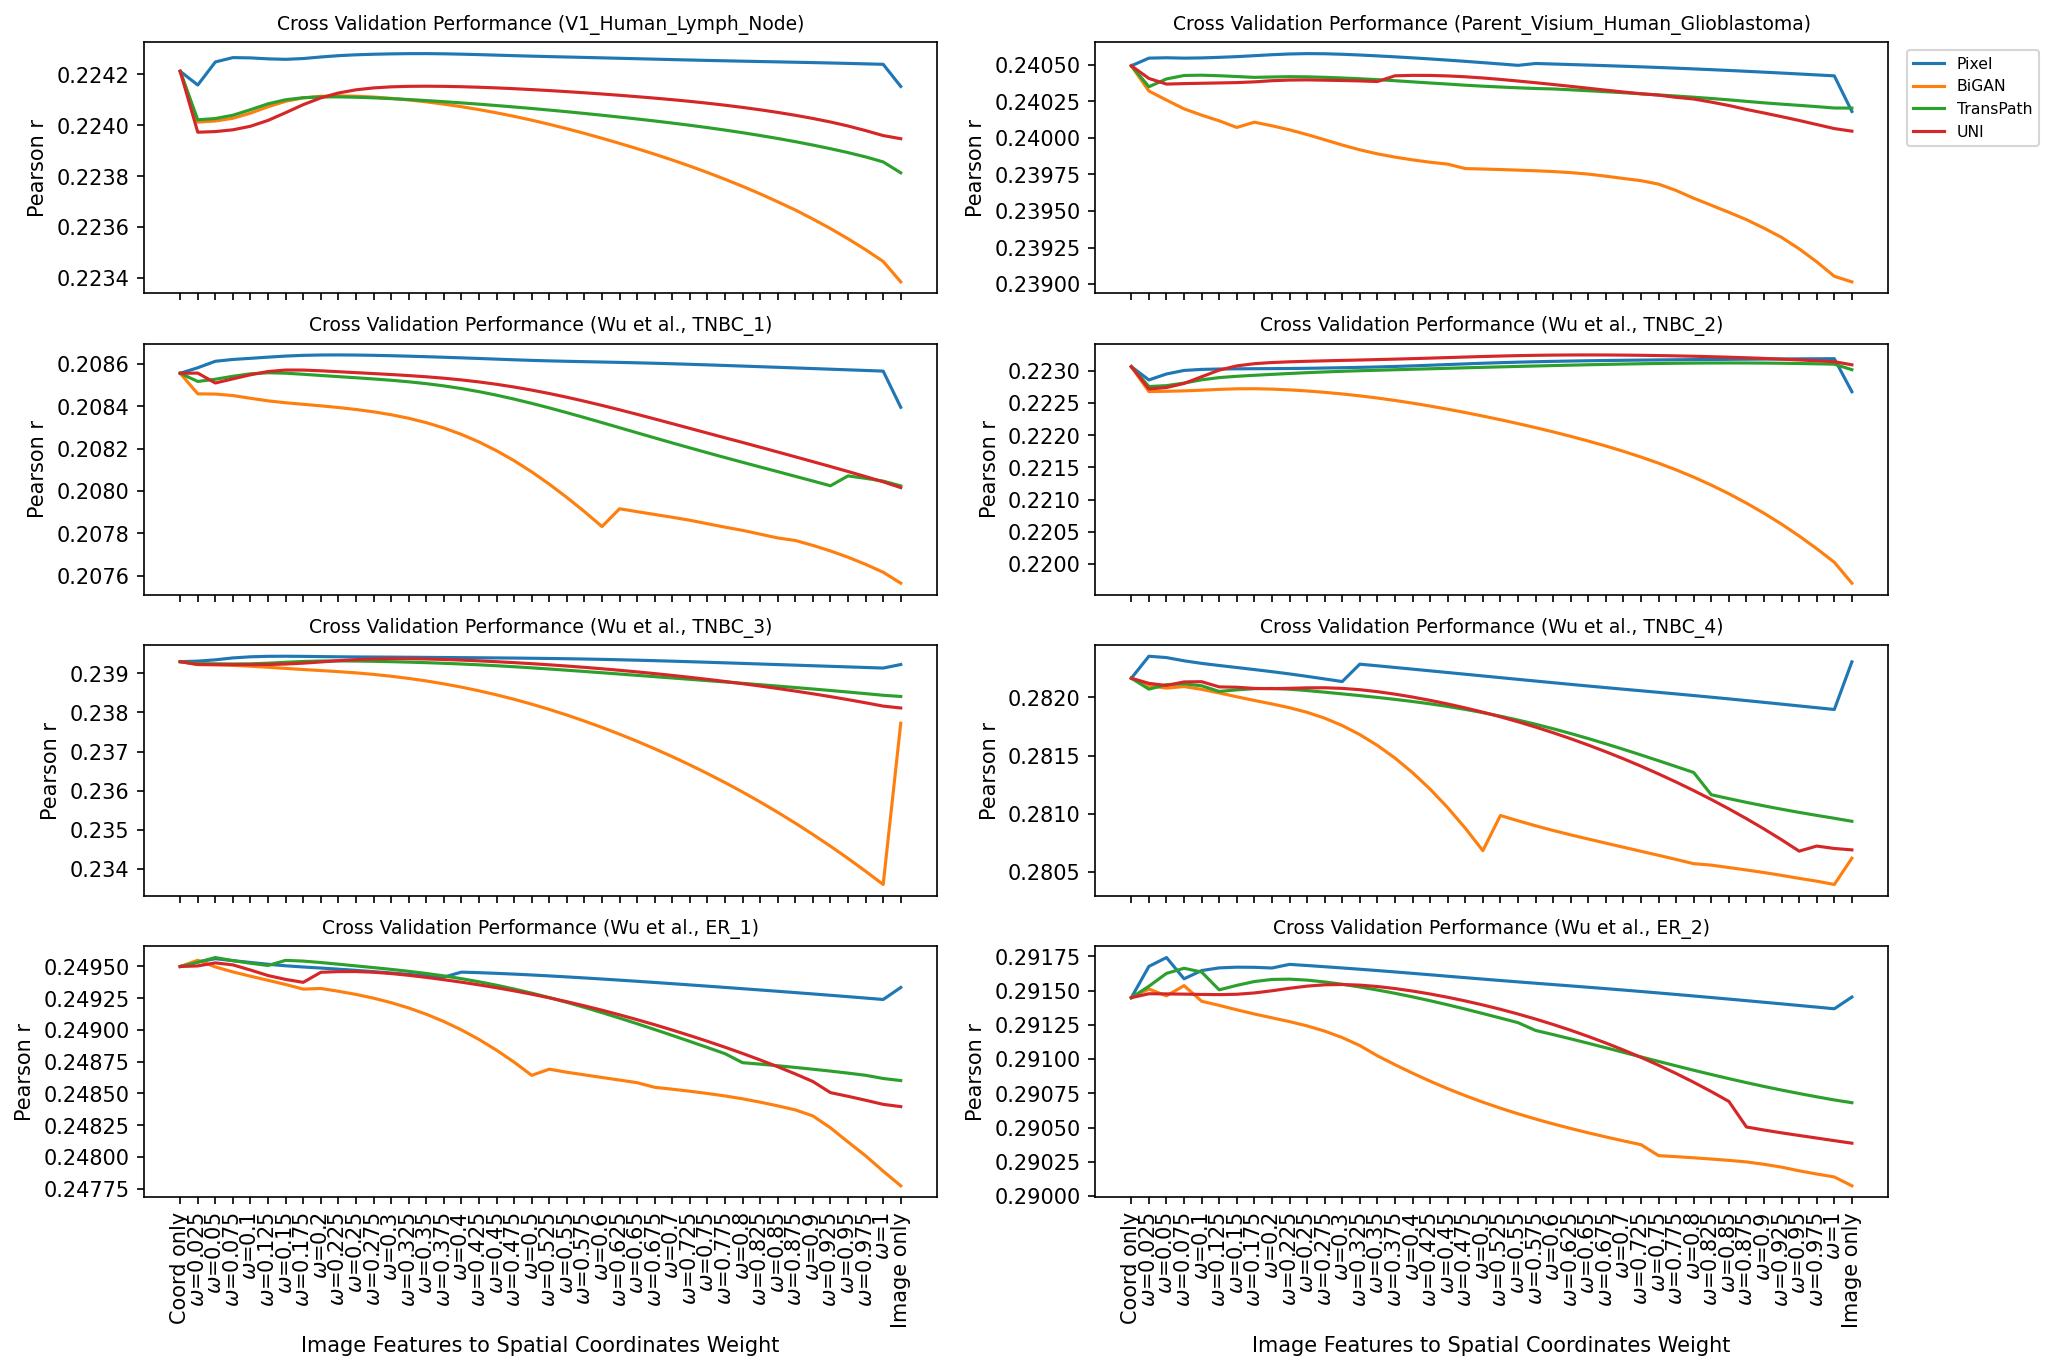

In [6]:
fig, axes = plt.subplots(4,2, figsize=(figsize*6, figsize*4), dpi=dpi, sharex=True)
plt.rc('font', size=7.5) 

for i in range(4):
    for j in range(2):
        sample = list(sample_list2.keys())[2*i+j]
        for col in ['Pixel', 'BiGAN', 'TransPath', 'UNI']:
            axes[i][j].plot(dfs_mean[sample][col], label=col)
#         axes[i][j].set_xlabel('Image Features to Spatial Coordinates Weight')
        axes[i][j].set_ylabel('Pearson r')
#         axes[i][j].set_xticks(axes[i][j].get_xticks(), axes[i][j].get_xticklabels(), rotation=90)
        axes[i][j].set_title(f"Cross Validation Performance ({sample_list2[sample]})")

axes[0][1].legend(title='', loc='upper right', bbox_to_anchor=(1.2, 1))
for j in range(2):
    axes[i][j].set_xlabel('Image Features to Spatial Coordinates Weight')
    axes[i][j].set_xticks(axes[i][j].get_xticks(), axes[i][j].get_xticklabels(), rotation=90)

## Wilcoxon test

In [7]:
weight_index = '0.1_consolidated'

dfs_pcc = dict()
for sample in sample_list:
    dfs_pcc[sample] = pd.read_csv(f'outputs_image_weight/{weight_index}/{sample}.csv', index_col=0)
    dfs_pcc[sample].columns = ['TransPath', 'Pixel', 'BiGAN', 'UNI']
    
dfs_wilcoxon = []
for sample in sample_list:
    df_mean = dfs_mean[sample]
    x = dfs_pcc[sample]['Pixel']
    for method in ['TransPath', 'BiGAN', 'UNI']:
        y = dfs_pcc[sample][method]
        mean = df_mean.loc['$\omega$=0.1', 'Pixel'] - df_mean.loc['$\omega$=0.1', method] 
        dfs_wilcoxon.append([sample, method, mean, np.mean(x-y), wilcoxon(x, y, alternative='greater')[1]])
#         dfs_wilcoxon.append([sample, method, -mean, np.mean(y-x), wilcoxon(y, x, alternative='greater')[1]])
        
dfs_wilcoxon = pd.DataFrame(dfs_wilcoxon, columns = ['Sample', 'Method', 'Difference (pre_calc)', 'Difference (post_calc)', 'p_adj'])
dfs_wilcoxon["negative_log_p_adj"] = -np.log10(dfs_wilcoxon["p_adj"]+1e-10)

dfs_wilcoxon.to_csv(f'outputs_image_weight/df_wilcoxon_stan.csv')


In [8]:
dfs_wilcoxon

,Sample,Method,Difference (pre_calc),Difference (post_calc),p_adj,negative_log_p_adj
0,V1_Human_Lymph_Node,TransPath,0.000204,0.000204,9.999999e-01,4.876523e-08
1,V1_Human_Lymph_Node,BiGAN,0.000217,0.000217,9.999981e-01,8.385070e-07
2,V1_Human_Lymph_Node,UNI,0.000269,0.000269,9.999973e-01,1.170079e-06
3,Parent_Visium_Human_Glioblastoma,TransPath,0.000118,0.000118,5.462937e-02,1.262574e+00
4,Parent_Visium_Human_Glioblastoma,BiGAN,0.000391,0.000391,1.086641e-07,6.963514e+00
5,Parent_Visium_Human_Glioblastoma,UNI,0.000173,0.000173,8.979502e-04,3.046748e+00
6,Breast_Wu_1142243F,TransPath,0.000073,0.000073,6.981768e-03,2.156035e+00
7,Breast_Wu_1142243F,BiGAN,0.000189,0.000189,3.393084e-10,9.357230e+00
8,Breast_Wu_1142243F,UNI,0.000078,0.000078,6.726926e-05,4.172183e+00
9,Breast_Wu_1160920F,TransPath,0.000162,0.000162,2.404333e-02,1.619005e+00


Text(0, 0.5, '')

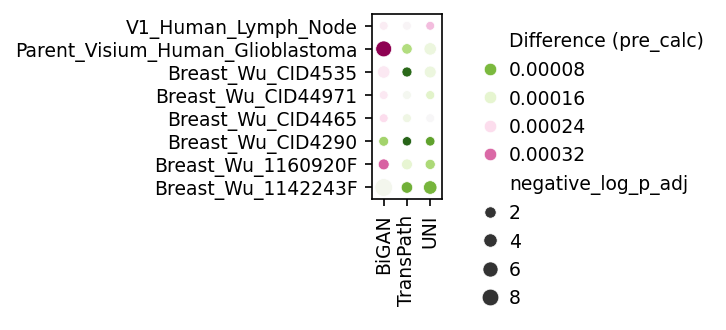

In [9]:
data = dfs_wilcoxon
y = 'Sample'
x = 'Method'
hue = 'Difference (pre_calc)'

data[x] = data[x].astype("category")
data[y] = data[y].astype("category")
x_lab = data[x].cat.categories
y_lab = data[y].cat.categories

figsize = 0.2
plt.figure(figsize=(figsize*len(x_lab), figsize*len(y_lab)), dpi=dpi)
plt.rc('font', size=fontsize) 
ax = sns.scatterplot(data=data,x=x, y=y, palette="PiYG_r", hue=hue, size="negative_log_p_adj")
plt.legend(bbox_to_anchor=(5,1.), loc='upper right', 
    columnspacing=0.5, handletextpad=0, frameon=False, fontsize=fontsize)

ax.set_xticklabels(x_lab, rotation = 90)
ax.set_xlim(-0.5, -0.5+len(x_lab))
ax.set_ylim(-0.5, -0.5+len(y_lab))
ax.set_xlabel("")
ax.set_ylabel("")

## Ridge

In [12]:
adatas = dict()
for sample in sample_list:
    adatas[sample] = sc.read_h5ad(f"outputs_stan/adata_{sample}.h5ad")
    adatas[sample].obs['pred_cor_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample}_pred_cor_ridge.csv', index_col=0)

In [13]:
dfs_pcc = dict()
for sample in sample_list:
    dfs_pcc[sample] = pd.read_csv(f'outputs_image_weight/fo_consolidated/{sample}.csv', index_col=0)
    dfs_pcc[sample].columns = ['Image Only (TransPath)', 'Image Only (Pixel)', 'Image Only (BiGAN)', 'Image Only (UNI)']
    df = pd.read_csv(f'outputs_image_weight/co_consolidated/{sample}.csv', index_col=0)
    dfs_pcc[sample]['Coord only'] = df['CTP']
    dfs_pcc[sample]['Ridge'] = adatas[sample].obs['pred_cor_ridge']

In [14]:
df

,CTP,RGB,BiGAN,UNI
index,,,,
CID4535_AAACAATCTACTAGCA-1,0.260791,0.260791,0.260791,0.260791
CID4535_AAACACCAATAACTGC-1,0.370815,0.370815,0.370815,0.370815
CID4535_AAACAGTGTTCCTGGG-1,0.288274,0.288274,0.288274,0.288274
CID4535_AAACCGTTCGTCCAGG-1,0.322098,0.322098,0.322098,0.322098
CID4535_AAACGAGACGGTTGAT-1,0.226809,0.226809,0.226809,0.226809
...,...,...,...,...
CID4535_TTGTTCAGTGTGCTAC-1,0.205795,0.205795,0.205795,0.205795
CID4535_TTGTTTCACATCCAGG-1,0.291034,0.291034,0.291034,0.291034
CID4535_TTGTTTCATTAGTCTA-1,0.282623,0.282623,0.282623,0.282623


In [15]:
dfs_wilcoxon = []
for sample in sample_list:
    df_mean = dfs_mean[sample]
    y = dfs_pcc[sample]['Ridge']
    for method in dfs_pcc[sample].columns[:-1]:
        x = dfs_pcc[sample][method]
        dfs_wilcoxon.append([sample, method, np.mean(x-y), wilcoxon(x, y, alternative='greater')[1]])
#         dfs_wilcoxon.append([sample, method, -mean, np.mean(y-x), wilcoxon(y, x, alternative='greater')[1]])
        
dfs_wilcoxon = pd.DataFrame(dfs_wilcoxon, columns = ['Sample', 'Method', 'Difference', 'p_adj'])
dfs_wilcoxon["negative_log_p_adj"] = -np.log10(dfs_wilcoxon["p_adj"]+1e-10)

dfs_wilcoxon.to_csv(f'outputs_image_weight/df_wilcoxon_ridge.csv')


In [16]:
mat_wilcoxon = pd.DataFrame(columns=dfs_pcc.keys(), 
                            index=['Ridge', 'Coord only', 'Image Only (Pixel)', 'Image Only (TransPath)', 'Image Only (BiGAN)', 'Image Only (UNI)'])
for sample in sample_list:
    mat_wilcoxon[sample] = dfs_pcc[sample].mean()
    
mat_wilcoxon.index = ['Ridge', 'Coord only', 'Image Only\n(Pixel)', 'Image Only\n(TransPath)', 'Image Only\n(BiGAN)', 'Image Only\n(UNI)']

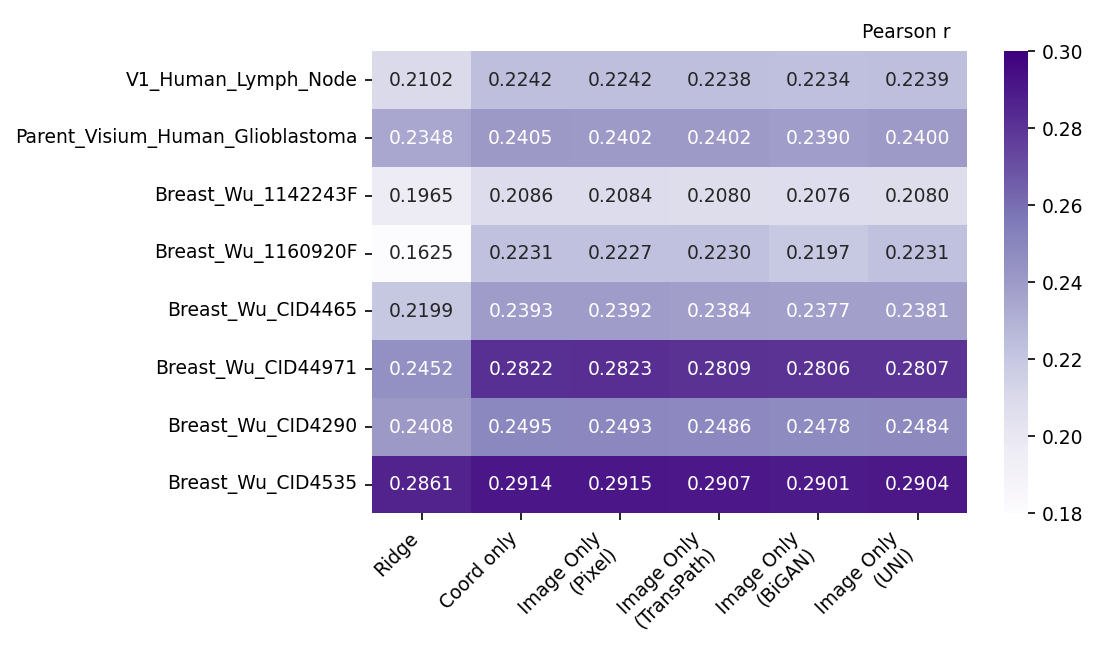

In [17]:
plt.figure(figsize=(6.4, 4), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(mat_wilcoxon.T, cmap="Purples", annot=True, vmax=0.3, vmin=0.18, fmt='.4f')
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
# plt.title(title)
plt.legend(title='Pearson r', frameon=False, bbox_to_anchor=(1.,1.1))


In [18]:
mat_wilcoxon_p = pd.DataFrame(columns=dfs_pcc.keys(), 
                            index=['Coord only', 'Image Only (Pixel)', 'Image Only (TransPath)', 'Image Only (BiGAN)', 'Image Only (UNI)'])
for sample in sample_list:
    for method in mat_wilcoxon_p.index:
        x = dfs_pcc[sample][method]
        y = dfs_pcc[sample]['Ridge']
        print(wilcoxon(x, y, alternative='greater'))
        mat_wilcoxon_p.loc[method, sample] = -np.log10(wilcoxon(x, y, alternative='greater')[1]+1e-300)
    
mat_wilcoxon_p.index = ['Coord only', 'Image Only\n(Pixel)', 'Image Only\n(TransPath)', 'Image Only\n(BiGAN)', 'Image Only\n(UNI)']

WilcoxonResult(statistic=nan, pvalue=nan)
WilcoxonResult(statistic=nan, pvalue=nan)
WilcoxonResult(statistic=nan, pvalue=nan)
WilcoxonResult(statistic=nan, pvalue=nan)
WilcoxonResult(statistic=nan, pvalue=nan)
WilcoxonResult(statistic=5327094.0, pvalue=0.0)
WilcoxonResult(statistic=5230092.0, pvalue=0.0)
WilcoxonResult(statistic=5419033.0, pvalue=0.0)
WilcoxonResult(statistic=4816971.0, pvalue=1.746705986569447e-210)
WilcoxonResult(statistic=5396963.0, pvalue=0.0)
WilcoxonResult(statistic=10662817.0, pvalue=0.0)
WilcoxonResult(statistic=10634475.0, pvalue=0.0)
WilcoxonResult(statistic=10663870.0, pvalue=0.0)
WilcoxonResult(statistic=10489944.0, pvalue=0.0)
WilcoxonResult(statistic=10656999.0, pvalue=0.0)
WilcoxonResult(statistic=11667369.0, pvalue=0.0)
WilcoxonResult(statistic=11647716.0, pvalue=0.0)
WilcoxonResult(statistic=11681084.0, pvalue=0.0)
WilcoxonResult(statistic=11561469.0, pvalue=0.0)
WilcoxonResult(statistic=11685262.0, pvalue=0.0)
WilcoxonResult(statistic=681141.0, pvalue

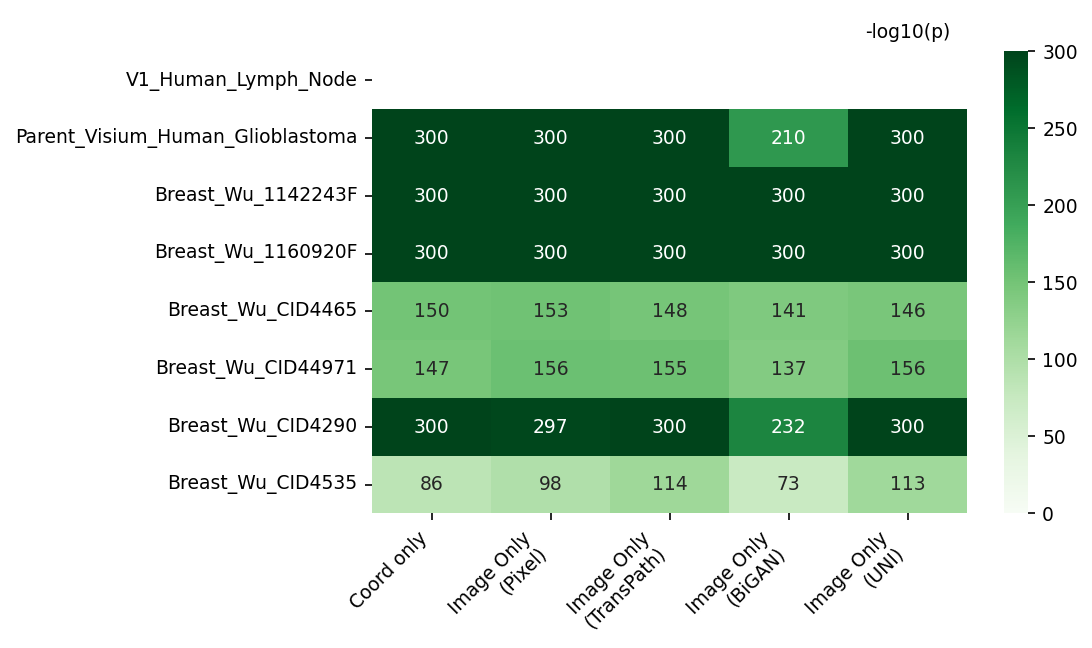

In [19]:
plt.figure(figsize=(6.4, 4), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(mat_wilcoxon_p.T.astype(float), cmap="Greens", annot=True, vmax=300, vmin=0, fmt='.0f')
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
# plt.title(title)
plt.legend(title='-log10(p)', frameon=False, bbox_to_anchor=(1.,1.1))


In [20]:
mat_stan = pd.DataFrame(index=dfs_pcc.keys(), 
                        columns=['Image only mean', 'Image only std', 'Coord only mean', 'Coord only std', 'p val'])
for sample in sample_list:
    mat_stan.loc[sample, 'Coord only mean'] = dfs_pcc[sample]['Coord only'].mean()
    mat_stan.loc[sample, 'Coord only std'] = dfs_pcc[sample]['Coord only'].std()
    mat_stan.loc[sample, 'Image only mean'] = dfs_pcc[sample]['Image Only (Pixel)'].mean()
    mat_stan.loc[sample, 'Image only std'] = dfs_pcc[sample]['Image Only (Pixel)'].std()
    mat_stan.loc[sample, 'p val'] = wilcoxon(dfs_pcc[sample]['Image Only (Pixel)'], 
                                             dfs_pcc[sample]['Coord only'], alternative='greater')[1]

In [21]:
mat_stan

,Image only mean,Image only std,Coord only mean,Coord only std,p val
V1_Human_Lymph_Node,0.224153,0.014084,0.224212,0.014183,0.0
Parent_Visium_Human_Glioblastoma,0.240181,0.034022,0.240493,0.034364,0.9443
Breast_Wu_1142243F,0.208396,0.029577,0.208556,0.030311,0.970486
Breast_Wu_1160920F,0.222677,0.035706,0.223067,0.037623,0.000111
Breast_Wu_CID4465,0.239226,0.03931,0.239299,0.038773,0.89396
Breast_Wu_CID44971,0.282306,0.049711,0.282165,0.048981,0.431752
Breast_Wu_CID4290,0.249335,0.038205,0.2495,0.039505,0.010146
Breast_Wu_CID4535,0.291453,0.050681,0.291448,0.049737,0.938605
